# 1. Datos
El dataset a ser usado contiene informacion de ventas por internet de 01/12/2010 a 09/12/2011 y es propiedad de
[The UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/index.php) 

## Descripcion de las columnas
Este DataSet contiene 8 columnas, con los siiguientes datos:<br>
**InvoiceNo**: Número de Recibo. Nominal, numero entero de 6 digitos unico por cada transaccion asignada. Si este numero inicia con la letra 'c' significa cancelacion.<br>
**StockCode**: Codigo del producto. Nominal, numero entero de 5 digitos, unico por cada producto distinto. <br>
**Description**: Nombre del producto. Nominal. <br>
**Quantity**: Cantidad de cada prodcto por transaccion. Numerico.	<br>
**InvoiceDate**: Fecha y hora de la factura. Numérico, el día y la hora en que se generó cada transacción. <br>
**UnitPrice**: Precio unitario. Numérico, precio del producto por unidad en libras esterlinas. <br>
**CustomerID**: Número de cliente. Nominal, un número entero de 5 dígitos asignado exclusivamente a cada cliente. <br>
**Country**: Nombre del país. Nominal, el nombre del país donde reside cada cliente.<br>

En el siguiente bloque se ve todas las herramientas que seran usadas para el analisis de la informacion del data set

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

# 2. Carga de la informacion

In [2]:
# Lectura del csv
df_initial = pd.read_csv('data.csv',encoding="ISO-8859-1",
                         dtype={'CustomerID': str,'InvoiceID': str})
# Mostramos la dimension del DataFrame
print('Dimension de DataFrame:', df_initial.shape)

# Convertimo la columna InvoiceDate a tipo de dato datetime
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])

# Mostramos informacion sobre las columnas del data set
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

# Mostramos las primeras 5 lineas del DataFrame
display(df_initial[:5])

Dimension de DataFrame: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,1454,0,0,0,135080,0
null values (%),0,0,0.268311,0,0,0,24.9267,0


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


Observando la tabla anterior podemos notar que casi ∼∼ 25% de los registros no tienen asignado un **CustomerID**

En este caso no podemos asignar o hacer un imput de valores para esta columna, por lo tanto todos estos valores no son utiles.

Entonces vamos a quitarlos de nuestro DataFrame:

In [3]:
# Quitamos nulos
df_initial.dropna(axis = 0, subset = ['CustomerID'], inplace = True)

print('Dimension de DataFrame sin nulos:', df_initial.shape)

# Volvemos a visualizar el resumen de las columnas
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

Dimension de DataFrame sin nulos: (406829, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0


Lo siguiente que tenmos que quitar son los registro duplicados

In [4]:
print('Registros Duplicados: {}'.format(df_initial.duplicated().sum()))
df_initial.drop_duplicates(inplace = True)

Registros Duplicados: 5225


# 3. Explorando las varibles
Recordemos que estos son los campos que tenemos disponibles:
**InvoiceNo**: Número de Recibo. Nominal, numero entero de 6 digitos unico por cada transaccion asignada. Si este numero inicia con la letra 'c' significa cancelacion.<br>
**StockCode**: Codigo del producto. Nominal, numero entero de 5 digitos, unico por cada producto distinto. <br>
**Description**: Nombre del producto. Nominal. <br>
**Quantity**: Cantidad de cada prodcto por transaccion. Numerico.	<br>
**InvoiceDate**: Fecha y hora de la factura. Numérico, el día y la hora en que se generó cada transacción. <br>
**UnitPrice**: Precio unitario. Numérico, precio del producto por unidad en libras esterlinas. <br>
**CustomerID**: Número de cliente. Nominal, un número entero de 5 dígitos asignado exclusivamente a cada cliente. <br>
**Country**: Nombre del país. Nominal, el nombre del país donde reside cada cliente.<br>

## Paises
Vamos a explorar llos paises de donde provienen las ordenes

In [5]:
temp = df_initial[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print('Numero de paises distindos en el DataFrame: {}'.format(len(countries)))

Numero de paises distindos en el DataFrame: 37


Ahora visualicemos con un mapa de calor las ordenes por pais

In [6]:
data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'# Ordenes'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)

layout = dict(title='Numero de ordenes por pais',
geo = dict(showframe = True, projection={'type':'mercator'}))

choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

De esta visualizacion podemos concluir que la mayor parte de los pedidos son de UK, teniendo mas de 19K registros 

## Clientes y Productos
El DataFrame contiene aproximadamente $\sim$400,000 registros.

Exploremos el numero de clientes y el numero de productos diferentes

In [7]:
pd.DataFrame([{'products': len(df_initial['StockCode'].value_counts()),    
               'transactions': len(df_initial['InvoiceNo'].value_counts()),
               'customers': len(df_initial['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3684,22190,4372


En la tabla de resumen que generamos podemos apreciar que tenemos 4372 clientes que realizaron $\sim$22000 transacciones y compraron 3684 productos diferentes.

Ahora veamos el numero de productos que fueron pagados en cada transaccion.

In [8]:
temp = df_initial.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
products_per_cart = temp.rename(columns = {'InvoiceDate':'Number of products'})
products_per_cart[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
5,12347,556201,18
6,12347,562032,22
7,12347,573511,47
8,12347,581180,11
9,12348,539318,17


Con la tabla anterior podemos notar los siguiente escenarios:

- La presencia de la letra 'C' en el registro 1 y esto significa que esa transaccion fue cancelada
- Existen usuarios que solo pagar 1 producto
- Existen usuarios que realzian varios pedidos

## Ordenes canceladas

In [9]:
products_per_cart['order_canceled'] = products_per_cart['InvoiceNo'].apply(lambda x:int('C' in x))
display(products_per_cart[:5])

n1 = products_per_cart['order_canceled'].sum()
n2 = products_per_cart.shape[0]
print('Numero de ordenes canceladas: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0


Numero de ordenes canceladas: 3654/22190 (16.47%) 


In [10]:
display(df_initial.sort_values('CustomerID')[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-08-02 08:48:00,4.25,12347,Iceland
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26 14:30:00,0.55,12347,Iceland
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland


Visualizamos el DataFrame y podemos observar que cuando una transaccion se cancela, se genera una nueva identica excepto por  **InvoiceNo** y **Quantity**

Vamos a verificar si esto ocurre para todas las ordenes canceladas

In [11]:
df_check = df_initial[df_initial['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]
for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[2])].shape[0] == 0: 
        print(df_check.loc[index])
        print('-'+'>'+' No cumple')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
-> No cumple


Como podemos observar en el resumen anterior las caracteristicas de los registros que no se pudieron encontrar son **Discount**

Vamos a descartar los casos en los que la descripcion sea **Discount**

In [12]:
df_check = df_initial[(df_initial['Quantity'] < 0) & (df_initial['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]

for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[2])].shape[0] == 0: 
        print(index, df_check.loc[index])
        print('-'+'>'+' No cumple')
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
-> No cumple


In [13]:
df_cleaned = df_initial.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  df_initial.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df_initial[(df_initial['CustomerID'] == col['CustomerID']) &
                         (df_initial['StockCode']  == col['StockCode']) & 
                         (df_initial['InvoiceDate'] < col['InvoiceDate']) & 
                         (df_initial['Quantity']   > 0)].copy()

    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)

    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        

        
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break            

In [14]:
print("Cancelacion con contraparte: {} representa {:.2f}%".format(len(entry_to_remove),len(entry_to_remove)/len(df_cleaned)*100))
print("Cancelacion sin contraparte: {} representa {:.2f}%".format(len(doubtfull_entry),len(doubtfull_entry)/len(df_cleaned)*100))

Cancelacion con contraparte: 7521 representa 1.87%
Cancelacion sin contraparte: 1226 representa 0.31%


La cantidad de registros no es representativa por lo tanto ambos casos seran eliminados

In [15]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)

In [16]:
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("Resagos: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

Resagos: 48


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
77598,C542742,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,-94,2011-01-31 16:26:00,0.65,15358,United Kingdom,0
90444,C544038,22784,LANTERN CREAM GAZEBO,-4,2011-02-15 11:32:00,4.95,14659,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048,United Kingdom,0
116064,C546191,47566B,TEA TIME PARTY BUNTING,-35,2011-03-10 10:57:00,0.70,16422,United Kingdom,0
132642,C547675,22263,FELT EGG COSY LADYBIRD,-49,2011-03-24 14:07:00,0.66,17754,United Kingdom,0


## StockCode
Vamos a explorar la informacion que tiene los codigos especiales de Stock

In [17]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

Obtenemos listados los distintos tipo de transacciones

In [18]:
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                


## Carrito
Necesitamos una variable que almacene la informacion del costo total de la compra de cada item

In [19]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,74215,0.0
148288,549222,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-04-07 10:43:00,4.25,12347,Iceland,0,17.0
428971,573511,22698,PINK REGENCY TEACUP AND SAUCER,12,2011-10-31 12:25:00,2.95,12347,Iceland,0,35.4
428970,573511,47559B,TEA TIME OVEN GLOVE,10,2011-10-31 12:25:00,1.25,12347,Iceland,0,12.5
428969,573511,47567B,TEA TIME KITCHEN APRON,6,2011-10-31 12:25:00,5.95,12347,Iceland,0,35.7


Calculamos el total dentro de una orden, para poder visualizar como se distribuyen las ordenes por monto

In [20]:
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
cart_price = temp.rename(columns = {'TotalPrice':'Cart Price'})

df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
cart_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

cart_price = cart_price[cart_price['Cart Price'] > 0]
cart_price.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,Cart Price,InvoiceDate
1,12347,537626,711.79,2010-12-07 14:57:00.000001024
2,12347,542237,475.39,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,2011-04-07 10:42:59.999999232
4,12347,556201,382.52,2011-06-09 13:01:00.000000256
5,12347,562032,584.91,2011-08-02 08:48:00.000000000
6,12347,573511,1294.32,2011-10-31 12:25:00.000001280


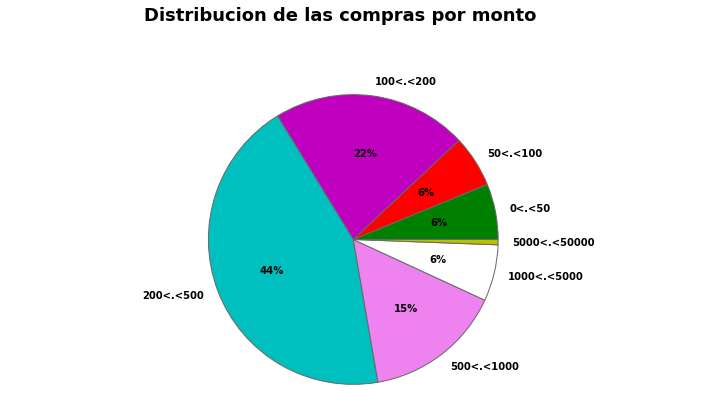

In [21]:
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = cart_price[(cart_price['Cart Price'] < price) &
                       (cart_price['Cart Price'] > price_range[i-1])]['Cart Price'].count()
    count_price.append(val)
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['g', 'r', 'm', 'c', 'violet', 'w','y']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribucion de las compras por monto", ha='center', fontsize = 18);

In [23]:
cart_price.describe()

,Cart Price
count,18398.000000
mean,456.338095
std,924.771216
min,0.380000
25%,155.355000
50%,299.390000
75%,462.957500
max,30757.000000


La mayor parte de las compras se encuentra dentro del monto de 200

# 4. Categorias de Productos

Debemos intentar extraer la informacion de las categorias de las compras para poder englobarlas y agruparlas.
___
La siguiente funcion tomara como entrada la informacion que limpiamos en el paso previo, y analizara el contenido de la columna **Description** 

* Con ayuda del modulo nltk vamos a procesar la cadena y extraeremos nombres propios y comunes
* Para cada nombre vamos a extraer la raiz semantica de la palabra y vamos a relizar una agregacion del set de palabras asociados a la raiz
* Contaremos el numero de veces que la raiz de la palabra aparece en el Dataframe 
___
La funcion nos devolvera:
- `keywords`: Lista de plabras clave 
- `keywords_roots`: Diccionario de las palabras asociadas a la raiz semantica de la palabra
- `count_keywords`: Diccionario del numero de veces que la palabra es usada

In [24]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, column = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[column]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Numero de Keywords en columna'{}': {}".format(column,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [25]:
df_products = pd.DataFrame(df_initial['Description'].unique()).rename(columns = {0:'Description'})

Ejecutamos la funcion para obtener el analizar la descripcon de los productos comprados

In [26]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_products)

Numero de Keywords en columna'Description': 1484


Convertimos el diccionario `count_keywords` en una lista para odenar las palabras segun su ocurrencia:

In [27]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

Ahora visualizamos la lista d epalabras por ocurrencia

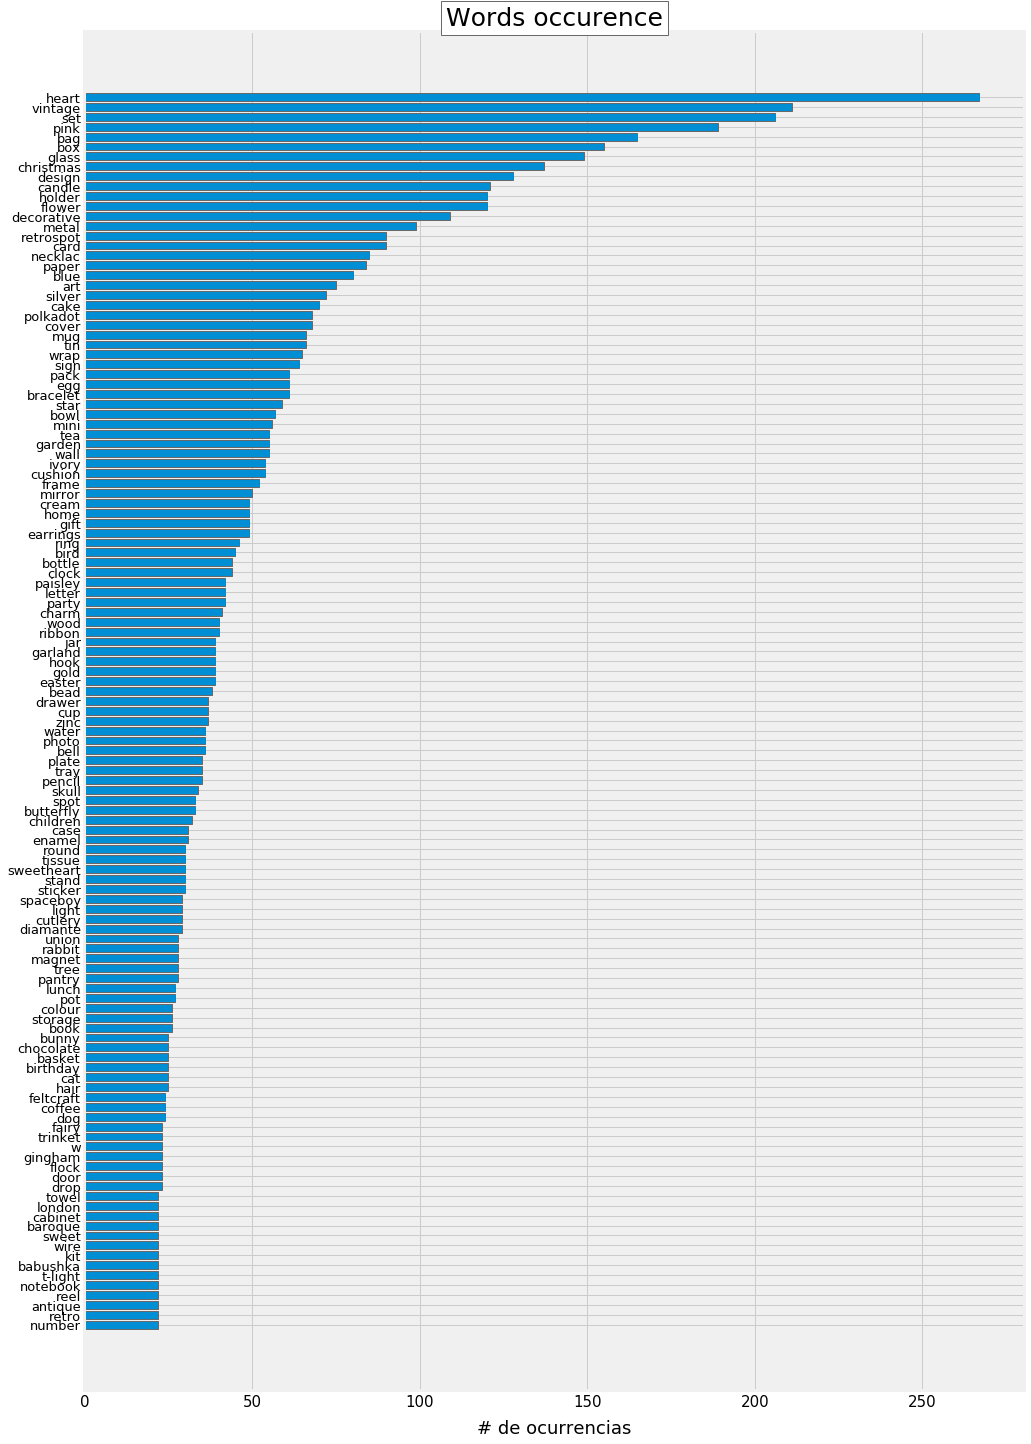

In [28]:
lst = sorted(list_products, key = lambda x:x[1], reverse = True)

plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(15, 25))
y_axis = [i[1] for i in lst[:125]]
x_axis = [k for k,i in enumerate(lst[:125])]
x_label = [i[0] for i in lst[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("# de ocurrencias", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
plt.title("Words occurence",bbox={'facecolor':'w', 'pad':5}, color='k',fontsize = 25)
plt.show()

## Definicion de Categorias
Se logro sintetizar mas de 1400 Keywords y los mas frecuentes aparecene en mas de 200 productos. Ahora procedemos a realizar una depuracion de palabras que no aportan nada de informacion como **colores** y aquellas palabra que no se repitan mas de 13 veces 

In [29]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
    
list_products.sort(key = lambda x:x[1], reverse = True)
print('Palabras restantes:', len(list_products))

Palabras restantes: 193


## Creacion de Grupos
Ya qu hemos depurado las categorias, vamos a crear grupos de productos 
____
Definiremos la matriz **X**:
___
|   | m 1  |  ...  | m j  | ...  | m N  |
|:-:|---|---|---|---|---|
| prodt 1  | $a_{1,1}$  |     |   |   | $a_{1,N}$  |
| ...        |            |     | ...  |   |   |
|prod i   |    ...     |     | $a_{i,j}$    |   | ...  |
|...         |            |     |  ... |   |   |
| prod M  | $a_{M,1}$  |     |   |   | $a_{M,N}$   |
___

Donde $a_ {i, j}$ es 1 si la drescripcion del producto $i$ contiene la palabra $j$, de lo contrario es 0.

De esta manera relizamos el *one-hot-encoding* 

In [30]:
products = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), products))

Lista final de KeyWords

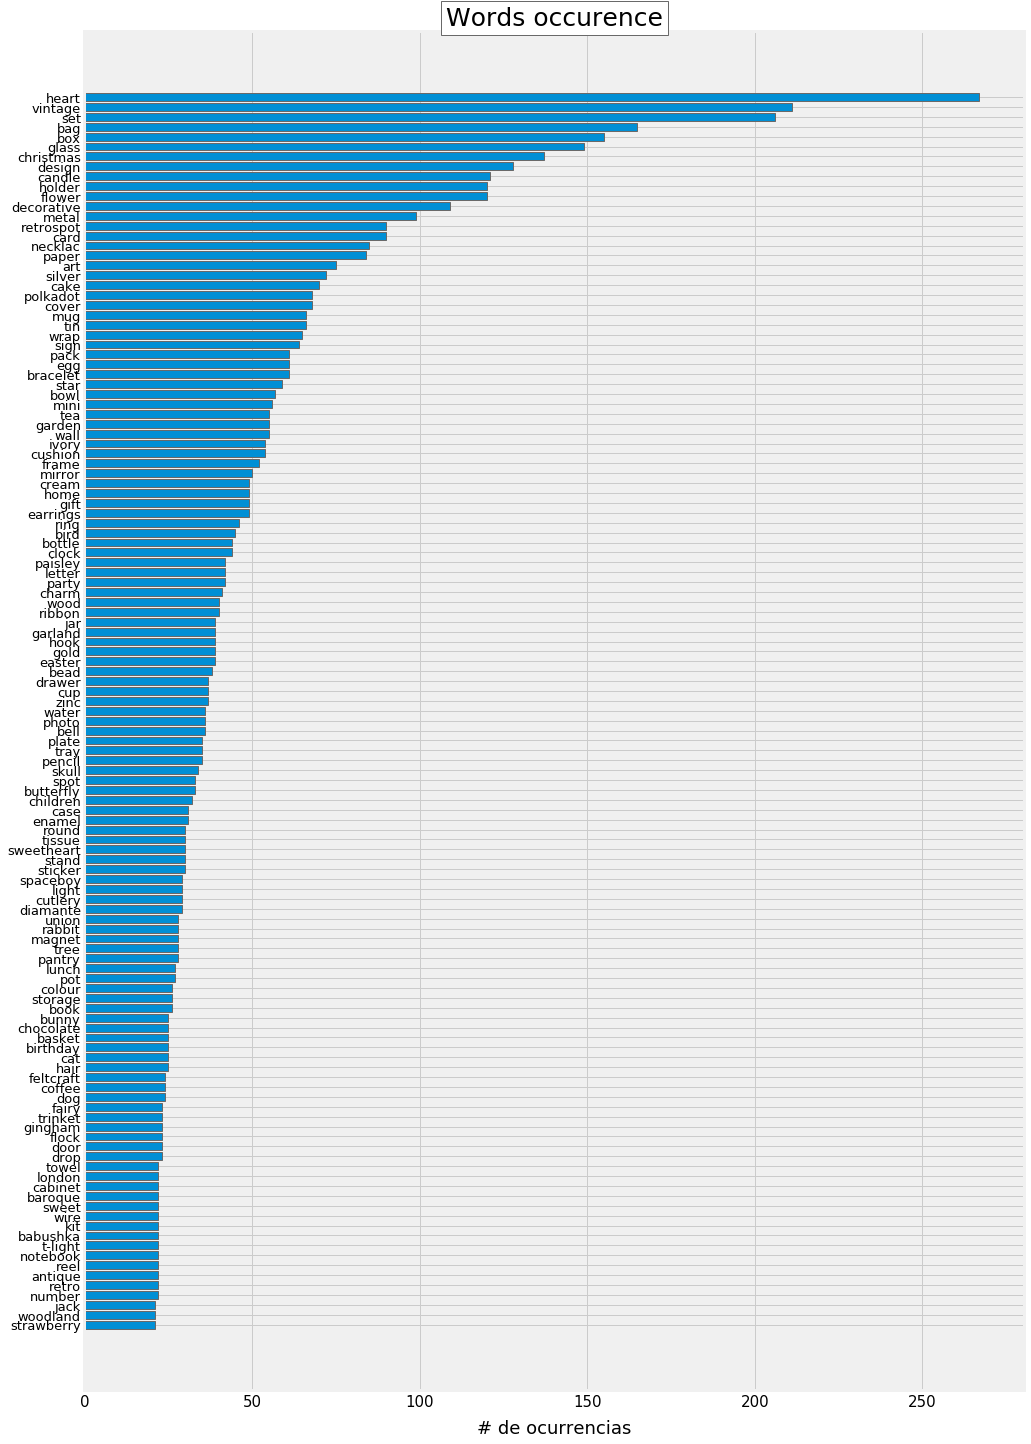

In [31]:
lst = sorted(list_products, key = lambda x:x[1], reverse = True)

plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(15, 25))
y_axis = [i[1] for i in lst[:125]]
x_axis = [k for k,i in enumerate(lst[:125])]
x_label = [i[0] for i in lst[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("# de ocurrencias", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
plt.title("Words occurence",bbox={'facecolor':'w', 'pad':5}, color='k',fontsize = 25)
plt.show()

In [32]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(products):
    prix = df_cleaned[ df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

Para mejorar las posibilidades del clustring vamos a incluir los rangos de precio para los productos que representan las keywords

In [33]:
print("{:<8} {:<20} \n".format('rango', '# productos') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

rango    # productos          
--------------------
0<.<1       964                 
1<.<2       1009                
2<.<3       673                 
3<.<5       606                 
5<.<10      470                 
.>10        156                 


In [34]:
#Finalmente esta es la matriz que vamos a clusterizar
X

,heart,vintage,set,bag,box,glass,christmas,design,candle,holder,...,lace,jewel,wallet,point,0<.<1,1<.<2,2<.<3,3<.<5,5<.<10,.>10
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3873,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3874,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3875,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3876,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


## Clustering de productos
Una vex ya teniendo definidas las keywords, vamos a clusterizar en clases nuestros productos segun su descripcion
___
Utilizamos el K-means y la metrica que usaremos para esto sera la metrica de Hamming.
___
Para definir mi numero de clusters usarmos el silhouette score

In [35]:
matrix = X
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("Para n_clusters =", n_clusters, "Promedio silhouette_score :", silhouette_avg)

Para n_clusters = 3 Promedio silhouette_score : 0.10071681758064248
Para n_clusters = 4 Promedio silhouette_score : 0.12609893747265383
Para n_clusters = 5 Promedio silhouette_score : 0.1210247232124736
Para n_clusters = 6 Promedio silhouette_score : 0.14544497724586775
Para n_clusters = 7 Promedio silhouette_score : 0.1523998566936536
Para n_clusters = 8 Promedio silhouette_score : 0.15436542130620282
Para n_clusters = 9 Promedio silhouette_score : 0.1585544223457706


La diferencia entre las distintas iteraciones nos ayuda a concluir que el posible numero de clusters que podemos escoger es 5

In [36]:
n_clusters = 5 #<- numero de clusters a generar
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("n_clusters =", n_clusters, "Promedio del silhouette_score:", silhouette_avg)

n_clusters = 5 Promedio del silhouette_score: 0.1260889572300933
n_clusters = 5 Promedio del silhouette_score: 0.14631355248870398


## Contenido de los Clusters
Verificamos el numero de elementos de nuestros clusters y las caracteristicas de los mismo

In [37]:
pd.Series(clusters).value_counts()

3    1009
4     964
1     829
2     606
0     470
dtype: int64

##  Silhouette Score
Necesitamos saber cual es la calidad de la clasificacion que realizamos en cada grupo generado, para ello vamos a representar el silhouette scores de cada elemento de cada cluster.

In [38]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
 
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        
        y_lower = y_upper + 10  

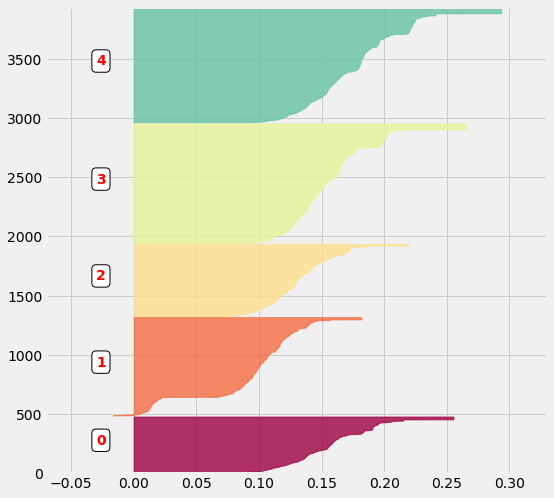

In [39]:
# silhouette score individual
sample_silhouette_values = silhouette_samples(matrix, clusters)
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

## Nube de Palabras
Visualizaremos los elementos literales o las kewords que cada grupo esta representando

In [40]:
lst = pd.DataFrame(products)
lst_words = [word for (word, occurence) in list_products]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    lst_cluster = lst.loc[clusters == i]
    for word in lst_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        occurence[i][word] = sum(lst_cluster.loc[:, 0].str.contains(word.upper()))

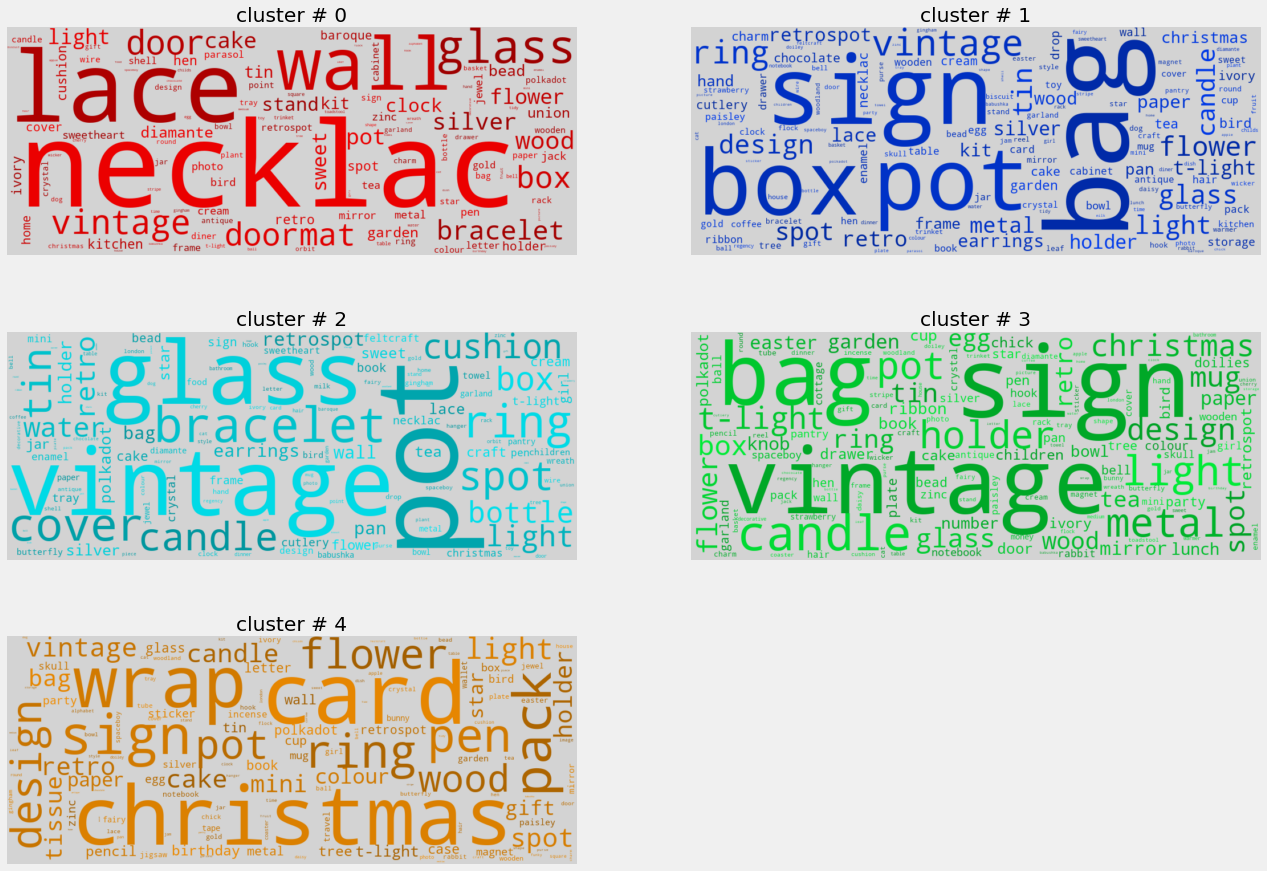

In [41]:

def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(80, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

def make_wordcloud(lst, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = lst[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]

    wordcloud = WordCloud(width=1000,height=400, background_color='lightgrey', 
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster # {}'.format(increment-1))

fig = plt.figure(1, figsize=(20,20))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurence[i]

    tone = color[i] # define the color of the words
    lst = []
    for key, value in list_cluster_occurences.items():
        lst.append([key, value])
    lst.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(lst, i+1)            

Podemos observar que el cluster 2 tiene elementos que pueden ser asociados con regalos, por ejemplo **christmas, card, pack,box,etc** pero en cambio el cluster 1 contiene elementos mas relacionados a joyeria **necklace, bracelete, lace, , silver, etc** 

Pero tambien se observa que existen varia palabras que se repiden en los clusters como **box,vintage, etc**

## Analisis de componente principales
Realizamos este analisis de PCA para verificar que los grupos son diferentes utilizando la matriz inicial de las variables que fueron agrupadas

In [42]:
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

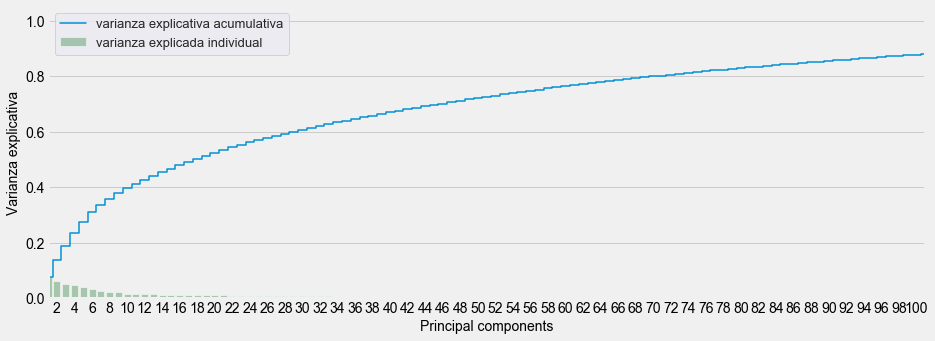

In [43]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='varianza explicativa acumulativa')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='varianza explicada individual')
plt.xlim(0, 100)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Varianza explicativa', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

Por el grafico podemos concluir que el numero de componentes que necesitamos para explicar los grupos es de 100, para explicar aproximadamente el 90% de la varianza en los datos. 

In [44]:
pca = PCA(n_components=50)
matrix_9D = pca.fit_transform(matrix)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

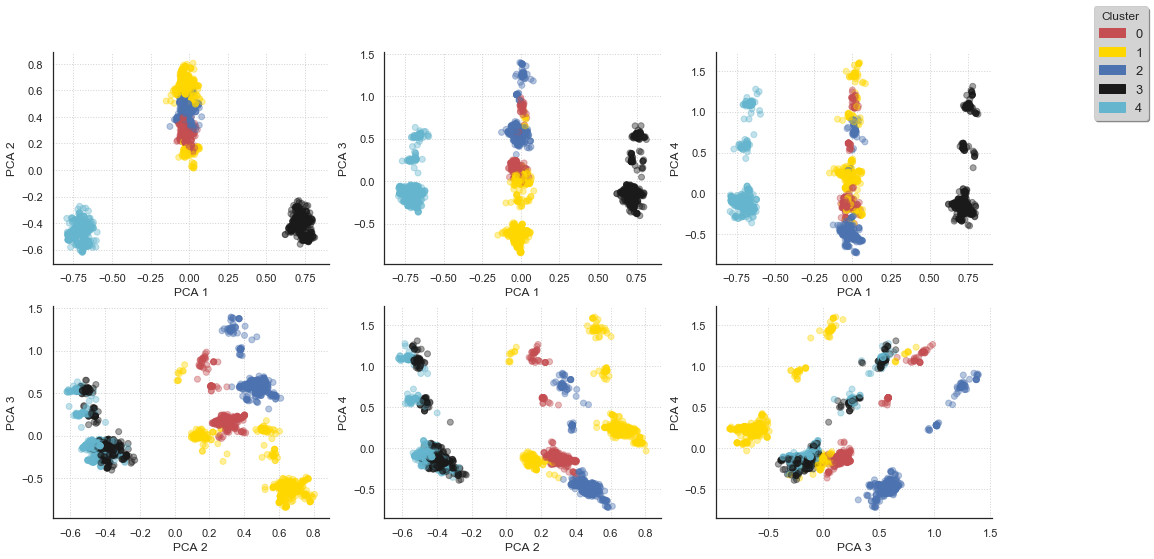

In [45]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (15,8))
increment = 0
for ix in range(4):
    for iy in range(ix+1, 4):    
        increment += 1
        ax = fig.add_subplot(2,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.4) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 9: break
    if increment == 9: break
        
comp_handler = []
for i in range(5):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.show()

# Clientes
## Categorizacion
En la seccion anterior realizamos el tratamiento de la informacion de productos concluyendo con la obtencio de 5 clusters, con este resultado vamos a categorizar los productos del data set limpio que usamos antes de la clustrizacion. 

In [46]:
corresp = dict()
for key, val in zip (products, clusters):
    corresp[key] = val 

df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,categ_product
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,15.30,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,2
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,22.00,2
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,2
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,2


Y ademas haremos una categorizacion de los gastos por categoria para los clusters que obtuvimos previamente

In [47]:
for i in range(5):
    col = 'categ_{}'.format(i)        
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)

df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']][:5]

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,1,0.0,15.3,0.00,0.0,0.0
1,536365,WHITE METAL LANTERN,2,0.0,0.0,20.34,0.0,0.0
2,536365,CREAM CUPID HEARTS COAT HANGER,2,0.0,0.0,22.00,0.0,0.0
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,2,0.0,0.0,20.34,0.0,0.0
4,536365,RED WOOLLY HOTTIE WHITE HEART.,2,0.0,0.0,20.34,0.0,0.0


Como mencionamos en un principio, la finformacion de las compras se encuentra presentada en varias filas, asi que debemos comprimirla en una sola fila que represente a todo la compra en global

In [48]:

temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
cart_price = temp.rename(columns = {'TotalPrice':'Cart Price'})

for i in range(5):
    col = 'categ_{}'.format(i) 
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    cart_price.loc[:, col] = temp 

df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
cart_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

cart_price = cart_price[cart_price['Cart Price'] > 0]
cart_price.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,InvoiceNo,Cart Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
1,12347,537626,711.79,124.44,83.40,293.35,187.2,23.40,2010-12-07 14:57:00.000001024
2,12347,542237,475.39,0.00,91.35,169.20,130.5,84.34,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,0.00,109.35,115.00,330.9,81.00,2011-04-07 10:42:59.999999232
4,12347,556201,382.52,19.90,78.06,168.76,74.4,41.40,2011-06-09 13:01:00.000000256
5,12347,562032,584.91,97.80,157.95,158.16,109.7,61.30,2011-08-02 08:48:00.000000000


## Separacion temporal
El DataFrame ´cart_price´ contiene la infromacion de un periodo de 12 meses. Para poder realizar una prediccion de las preferencias de compra de nuestros usuarios vamos ha separar nuestra muestra de 12 meses en 10 meses para generar el modelo y 2 meses para testear si la prediccion fue correcta

In [49]:
print(cart_price['InvoiceDate'].min(), '->',  cart_price['InvoiceDate'].max())

2010-12-01 08:26:00 -> 2011-12-09 12:50:00


In [50]:
cart_price.dtypes

CustomerID             object
InvoiceNo              object
Cart Price            float64
categ_0               float64
categ_1               float64
categ_2               float64
categ_3               float64
categ_4               float64
InvoiceDate    datetime64[ns]
dtype: object

In [51]:
set_entrainement = cart_price[cart_price['InvoiceDate'] < pd.Timestamp(datetime.date(2011,10,1))]
set_test         = cart_price[cart_price['InvoiceDate'] >= pd.Timestamp(datetime.date(2011,10,1))]
cart_price = set_entrainement.copy(deep = True)


In [52]:
set_entrainement

,CustomerID,InvoiceNo,Cart Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
1,12347,537626,711.79,124.44,83.40,293.35,187.20,23.40,2010-12-07 14:57:00.000001024
2,12347,542237,475.39,0.00,91.35,169.20,130.50,84.34,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,0.00,109.35,115.00,330.90,81.00,2011-04-07 10:42:59.999999232
4,12347,556201,382.52,19.90,78.06,168.76,74.40,41.40,2011-06-09 13:01:00.000000256
5,12347,562032,584.91,97.80,157.95,158.16,109.70,61.30,2011-08-02 08:48:00.000000000
...,...,...,...,...,...,...,...,...,...
18619,18283,557956,192.80,0.00,69.26,17.40,62.80,43.34,2011-06-23 19:20:00.000000000
18620,18283,560025,137.39,0.00,41.81,16.60,51.45,27.53,2011-07-14 13:00:00.000000000
18621,18283,560032,2.50,0.00,0.00,0.00,2.50,0.00,2011-07-14 13:20:00.000000000
18622,18283,565579,134.90,0.00,51.50,0.00,51.20,32.20,2011-09-05 12:34:59.999998720


## Perfilado de Cliente
Agrupamos todas las ordenes realizadas por el cliente para determinar el total que invirtio en cada categoria de producto

In [53]:
transactions_per_user=cart_price.groupby(by=['CustomerID'])['Cart Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = cart_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
cart_price.groupby(by=['CustomerID'])['categ_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347,5,382.52,711.79,558.172000,2790.86,8.676179,18.636191,32.408290,29.836681,10.442659
1,12348,4,227.44,892.80,449.310000,1797.24,0.000000,20.030714,0.000000,41.953217,38.016069
2,12350,1,334.40,334.40,334.400000,334.40,0.000000,39.862440,0.000000,48.444976,11.692584
3,12352,6,144.35,840.30,345.663333,2073.98,14.301006,56.603728,15.711338,12.892120,0.491808
4,12353,1,89.00,89.00,89.000000,89.00,22.359551,64.606742,0.000000,13.033708,0.000000


Finalmente se crean dos variables temporales que nos describiran la distancia entre la primera y la ultima compra

In [54]:
last_date = cart_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(cart_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(cart_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

transactions_per_user[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,12347,5,382.52,711.79,558.172000,2790.86,8.676179,18.636191,32.408290,29.836681,10.442659,59,297
1,12348,4,227.44,892.80,449.310000,1797.24,0.000000,20.030714,0.000000,41.953217,38.016069,5,288
2,12350,1,334.40,334.40,334.400000,334.40,0.000000,39.862440,0.000000,48.444976,11.692584,240,240
3,12352,6,144.35,840.30,345.663333,2073.98,14.301006,56.603728,15.711338,12.892120,0.491808,2,226
4,12353,1,89.00,89.00,89.000000,89.00,22.359551,64.606742,0.000000,13.033708,0.000000,134,134


In [55]:
transactions_per_user

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,12347,5,382.52,711.79,558.172000,2790.86,8.676179,18.636191,32.408290,29.836681,10.442659,59,297
1,12348,4,227.44,892.80,449.310000,1797.24,0.000000,20.030714,0.000000,41.953217,38.016069,5,288
2,12350,1,334.40,334.40,334.400000,334.40,0.000000,39.862440,0.000000,48.444976,11.692584,240,240
3,12352,6,144.35,840.30,345.663333,2073.98,14.301006,56.603728,15.711338,12.892120,0.491808,2,226
4,12353,1,89.00,89.00,89.000000,89.00,22.359551,64.606742,0.000000,13.033708,0.000000,134,134
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3603,18280,1,180.60,180.60,180.600000,180.60,34.025471,41.140642,24.833887,0.000000,0.000000,207,207
3604,18281,1,80.82,80.82,80.820000,80.82,0.000000,60.876021,0.000000,20.415739,18.708241,110,110
3605,18282,1,98.76,98.76,98.760000,98.76,0.000000,43.742406,13.669502,23.238153,19.349939,56,56
3606,18283,10,2.50,192.80,108.683000,1086.83,2.245061,35.455407,8.290165,36.805204,17.204163,25,267


In [56]:
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print("numero de clientes con unsa sola compra: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

numero de clientes con unsa sola compra: 1445/3608  (40.05%)


## Categorizacion de Clientes

In [57]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']

selected_customers = transactions_per_user.copy(deep = True)
matrix = selected_customers[list_cols]

In [58]:
scaler = StandardScaler()
scaler.fit(matrix)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

variables mean values: 
------------------------------------------------------------------------------------------
 [  3.62305987 259.93189634 556.26687999 377.06036244  15.67936332
  28.73795868  16.37327913  25.22916919  13.98907929]


In [59]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

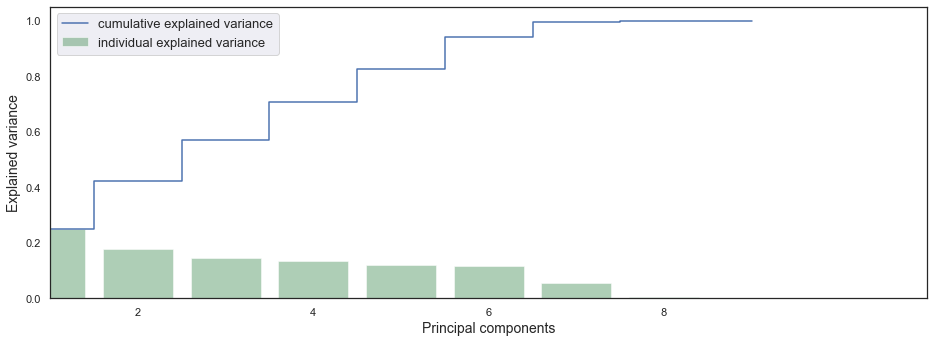

In [60]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

In [61]:
n_clusters = 11
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('score de silhouette: {:<.3f}'.format(silhouette_avg))

score de silhouette: 0.215


In [62]:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['nb. de clients']).T

,3,1,2,6,8,10,5,0,4,9,7
nb. de clients,1464,471,385,342,288,264,189,177,11,9,8


In [63]:
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

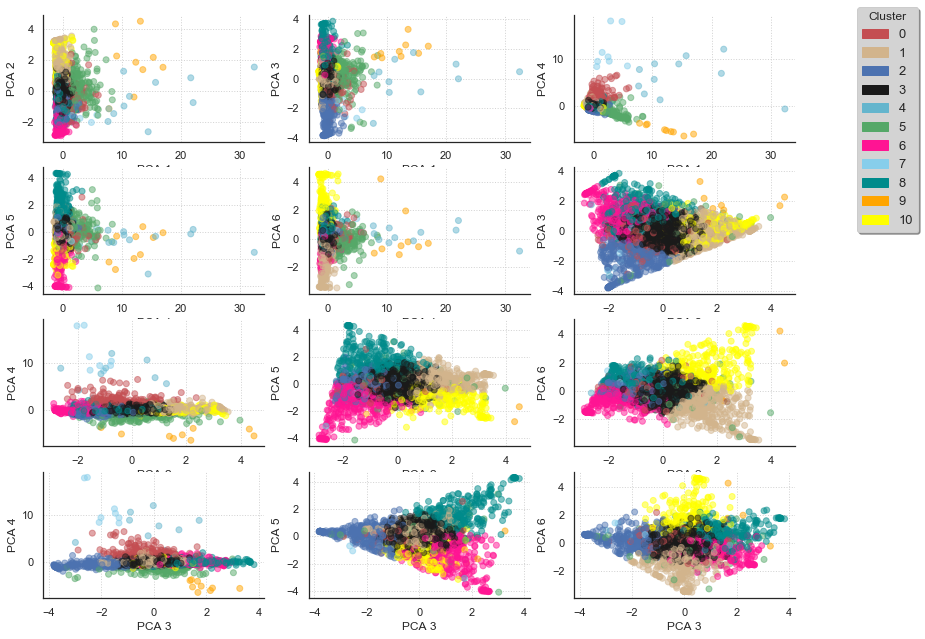

In [64]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan', 9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(6):
    for iy in range(ix+1, 6):   
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 12: break
    if increment == 12: break
        

comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()

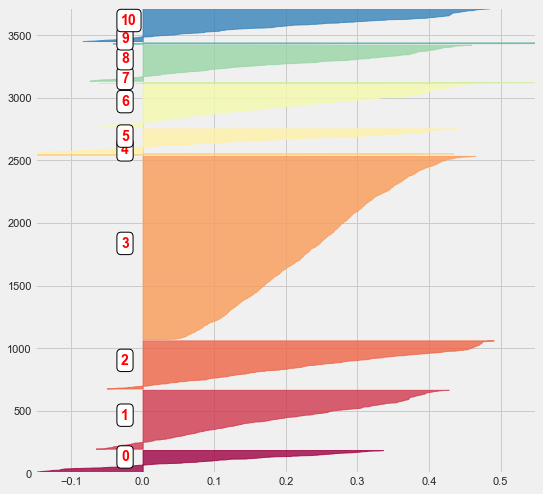

In [65]:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)

sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)

graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)

In [66]:
selected_customers.loc[:, 'cluster'] = clusters_clients

In [67]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])

merged_df.drop('CustomerID', axis = 1, inplace = True)
print('number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

number of customers: 3608


In [68]:
lst_index = []
for i in range(5):
    column = 'categ_{}'.format(i)
    lst_index.append(merged_df[merged_df[column] > 45].index.values[0])

lst_index_reordered = lst_index
lst_index_reordered += [ s for s in merged_df.index if s not in lst_index]

merged_df = merged_df.reindex(index = lst_index_reordered)
merged_df = merged_df.reset_index(drop = False)
display(merged_df[['cluster', 'count', 'min', 'max', 'mean', 'sum', 'categ_0',
                   'categ_1', 'categ_2', 'categ_3', 'categ_4', 'size']])

,cluster,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,size
0,6.0,2.485380,193.920526,310.242953,245.817029,626.083684,52.595230,17.794822,13.061040,11.383073,5.182334,342
1,2.0,2.366234,202.980961,350.878442,270.528371,701.523922,9.513762,67.511324,6.937699,10.853578,5.183638,385
2,8.0,2.125000,199.577986,333.122812,260.257246,643.292187,10.661761,17.567720,51.450649,13.733113,6.640538,288
3,1.0,2.426752,217.837155,332.445204,272.198566,673.416605,6.112132,16.602191,8.125818,56.820159,12.342861,471
4,10.0,2.250000,192.321515,319.554394,247.750107,592.993144,5.548648,13.511450,6.413428,19.655763,54.870710,264
5,3.0,3.189208,222.557508,460.193874,332.583289,1066.178997,14.772177,29.220509,17.066967,25.485890,13.458506,1464
6,5.0,1.735450,1067.063122,1431.836778,1236.015742,2283.370693,13.601153,31.663366,17.016803,25.783660,11.935375,189
7,9.0,1.222222,3901.461111,4064.098889,3982.780000,5032.047778,19.521209,19.188723,14.531229,20.388127,26.370713,9
8,0.0,16.977401,87.518079,1385.424350,525.541413,8554.370056,15.675302,31.529887,16.711419,24.051462,12.049633,177
9,7.0,87.125000,20.862500,2643.812500,456.526689,37313.235000,16.434535,32.965336,13.979829,25.165035,11.477885,8


In [69]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[1:-1]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
                
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)


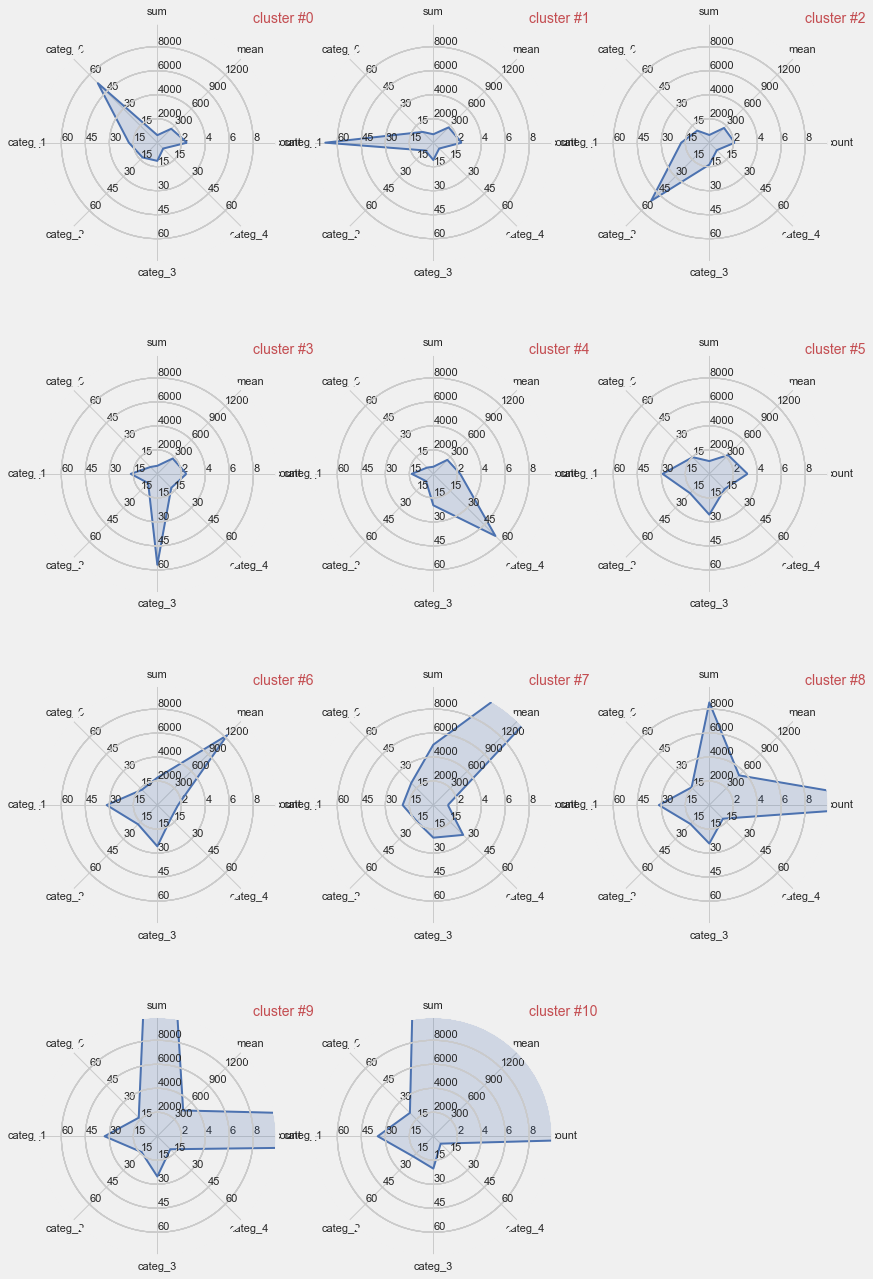

In [70]:
fig = plt.figure(figsize=(10,12))

attributes = ['count', 'mean', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
ranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

n_groups = n_clusters ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_clusters):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    
    data = np.array(merged_df.loc[index[ind], attributes])    
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster #{}'.format(index[ind]), color = 'r')
    ind += 1 